In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks
# pip install -e .

Found GPU at: /device:GPU:0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [0]:
seed = 12345
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Hyperparamters
epochs = 14

gamma = 0.7
momentum = 0.9

use_cuda = torch.cuda.is_available()
model_init = Net().to(device)

In [4]:
train_losses, test_losses = [], []
# lrs = [3e-1, 3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
# batch_size = 64 
batch_sizes = [32,64,128,256]
# batch_sizes = [32]
lr = 3e-6 # good one - lowest validation loss among others

var_gradients_list = []  

for batch_size in batch_sizes:
    model = copy.deepcopy(model_init)
    tmp_list = []
    tmp_train_list = []
    tmp_test_list = []
    print ("batch_size::", batch_size)
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))
    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
    # Training 
    for epoch in range(1, epochs + 1):
        train_loss, grad_norms, grad_avg = train_get_grad(model, device, train_loader, optimizer, epoch, batch_size)
        # train_losses.append(train_loss)
        tmp_train_list.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        # test_losses.append(test_loss)
        tmp_test_list.append(test_loss)
        scheduler.step()
        
        # computing var_score over one epoch
        variance_score = compute_grad_variance(grad_norms, grad_avg)
        # print ("var score", variance_score)
        tmp_list.append(variance_score)
    var_gradients_list.append(tmp_list)
    train_losses.append(tmp_train_list)
    test_losses.append(tmp_test_list)
    
# show_losses(train_losses, test_losses)

batch_size:: 32
54000 6000 10000

Test set: Average loss: 0.6675, Accuracy: 7581/10000 (76%)


Test set: Average loss: 0.6188, Accuracy: 7681/10000 (77%)


Test set: Average loss: 0.5952, Accuracy: 7729/10000 (77%)


Test set: Average loss: 0.5863, Accuracy: 7751/10000 (78%)


Test set: Average loss: 0.5789, Accuracy: 7752/10000 (78%)


Test set: Average loss: 0.5752, Accuracy: 7763/10000 (78%)


Test set: Average loss: 0.5710, Accuracy: 7770/10000 (78%)


Test set: Average loss: 0.5697, Accuracy: 7774/10000 (78%)


Test set: Average loss: 0.5680, Accuracy: 7770/10000 (78%)


Test set: Average loss: 0.5677, Accuracy: 7773/10000 (78%)


Test set: Average loss: 0.5674, Accuracy: 7773/10000 (78%)


Test set: Average loss: 0.5660, Accuracy: 7774/10000 (78%)


Test set: Average loss: 0.5666, Accuracy: 7775/10000 (78%)


Test set: Average loss: 0.5661, Accuracy: 7774/10000 (78%)

batch_size:: 64
54000 6000 10000

Test set: Average loss: 0.7181, Accuracy: 7315/10000 (73%)


Test set: Average 

var_gradients:
 [[tensor(1.9956), tensor(1.8365), tensor(1.6858), tensor(1.5881), tensor(1.5500), tensor(1.5077), tensor(1.4969), tensor(1.4742), tensor(1.4648), tensor(1.4424), tensor(1.4456), tensor(1.4324), tensor(1.4476), tensor(1.4339)]]


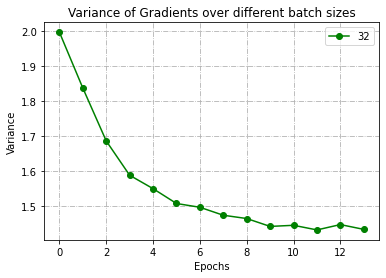

In [6]:
print ("var_gradients:\n", var_gradients_list)
import numpy as np
plt.plot(np.arange(epochs), var_gradients_list[0], marker='o', color = "g")
# plt.plot(np.arange(epochs), var_gradients_list[1], marker='o', color = "r")
# plt.plot(np.arange(epochs), var_gradients_list[2], marker='o', color = "b")
# plt.plot(np.arange(epochs), var_gradients_list[3], marker='o', color = "k")
plt.grid(True, linestyle='-.')
plt.legend(["32"]) #loc='lower left'
plt.title("Variance of Gradients over different batch sizes")
plt.ylabel("Variance")
plt.xlabel("Epochs")
plt.show()	  

var_gradients:
 [[tensor(1.9956), tensor(1.8365), tensor(1.6858), tensor(1.5881), tensor(1.5500), tensor(1.5077), tensor(1.4969), tensor(1.4742), tensor(1.4648), tensor(1.4424), tensor(1.4456), tensor(1.4324), tensor(1.4476), tensor(1.4339)], [tensor(1.4371), tensor(1.3835), tensor(1.3150), tensor(1.2462), tensor(1.2094), tensor(1.1926), tensor(1.1712), tensor(1.1553), tensor(1.1699), tensor(1.1538), tensor(1.1603), tensor(1.1561), tensor(1.1516), tensor(1.1443)], [tensor(1.1337), tensor(1.1840), tensor(1.1069), tensor(1.0662), tensor(1.0577), tensor(1.0215), tensor(1.0376), tensor(1.0161), tensor(1.0145), tensor(1.0061), tensor(1.0002), tensor(0.9836), tensor(0.9899), tensor(0.9881)], [tensor(0.7599), tensor(0.8146), tensor(0.8026), tensor(0.7905), tensor(0.7652), tensor(0.7462), tensor(0.7453), tensor(0.7608), tensor(0.7329), tensor(0.7346), tensor(0.7302), tensor(0.7353), tensor(0.7307), tensor(0.7354)]]


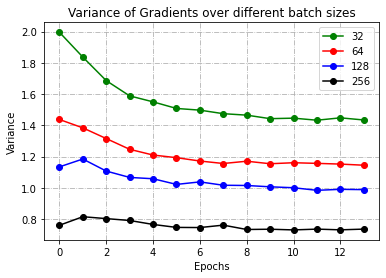

In [5]:
print ("var_gradients:\n", var_gradients_list)
import numpy as np
plt.plot(np.arange(epochs), var_gradients_list[0], marker='o', color = "g")
plt.plot(np.arange(epochs), var_gradients_list[1], marker='o', color = "r")
plt.plot(np.arange(epochs), var_gradients_list[2], marker='o', color = "b")
plt.plot(np.arange(epochs), var_gradients_list[3], marker='o', color = "k")
plt.grid(True, linestyle='-.')
plt.legend(["32","64","128","256"]) #loc='lower left'
plt.title("Variance of Gradients over different batch sizes")
plt.ylabel("Variance")
plt.xlabel("Epochs")
plt.show()	  

step:0:
 [-0.14373189 -0.02295541 -0.00961719  0.00149735  0.00577754  0.00951171
  0.01010575  0.01217663  0.01241561  0.0137337   0.01453984  0.01390077
  0.01490217  0.01478247]
step:1:
 [-0.1574907  -0.02022895 -0.00675555  0.00109813  0.00202328  0.00550131
  0.01015379  0.01001622  0.00830101  0.01058969  0.01121138  0.01207656
  0.01131817  0.01058391]
step:2:
 [-0.21173909 -0.02028208 -0.00885984  0.00319215  0.00243622  0.00105447
  0.0046945   0.00216345  0.01037939  0.00900108  0.01314035  0.00703095
  0.00638824  0.00657981]
step:3:
 [-0.29279729 -0.0303721  -0.00933875 -0.01277439 -0.01218719  0.00447041
  0.0047396  -0.00688026 -0.00167921  0.01129921  0.00259787  0.00036579
  0.00231768  0.00623245]
[[0.8112436315283109, 0.6418020935084724, 0.604768809919815, 0.5847941198125834, 0.5730968451224515, 0.5656808762594846, 0.5608991279368293, 0.5575604098451752, 0.555610401167477, 0.5539955148049652, 0.5528977443574447, 0.5520772562137147, 0.5517256657385501, 0.55133488633497

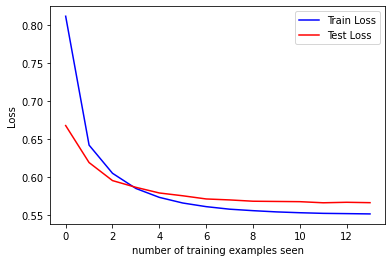

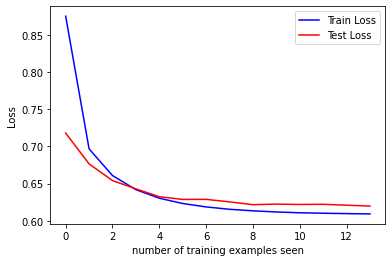

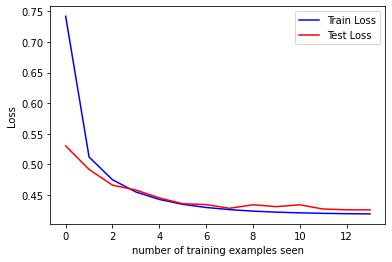

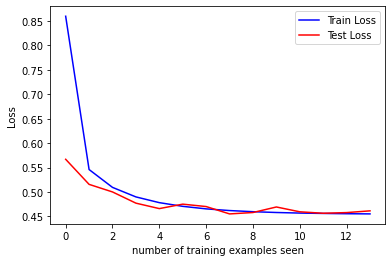

In [6]:
train_losses_copy = np.asarray(train_losses)
test_losses_copy = np.asarray(test_losses)

for i in range(len(train_losses_copy)):
    diff = test_losses_copy[i] - train_losses_copy[i]
    print ("step:"+str(i)+":\n", diff)
print (train_losses)
for i in range(len(train_losses_copy)):
    show_losses(train_losses_copy[i], test_losses_copy[i])


In [7]:
train_losses, test_losses = [], []
lrs = [3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
batch_size = 64 
# batch_sizes = [32,64,128,256]
# lr = 3e-6 # good one - lowest validation loss among others

var_gradients_list_lr = []  

for lr in lrs:
    model = copy.deepcopy(model_init)
    tmp_list = []
    tmp_train_list = []
    tmp_test_list = []
    print ("lrs::", lr)
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))
    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
    # Training 
    for epoch in range(1, epochs + 1):
        train_loss, grad_norms, grad_avg = train_get_grad(model, device, train_loader, optimizer, epoch, batch_size)
        tmp_train_list.append(train_loss)
        # train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        tmp_test_list.append(test_loss)
        # test_losses.append(test_loss)
        scheduler.step()
        
        # computing var_score over one epoch
        variance_score = compute_grad_variance(grad_norms, grad_avg)
        # print ("var score", variance_score)
        tmp_list.append(variance_score)
    var_gradients_list_lr.append(tmp_list)
    train_losses.append(tmp_train_list)
    test_losses.append(tmp_test_list)
    
# show_losses(train_losses, test_losses)

lrs:: 0.03
54000 6000 10000

Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)

lrs:: 0.003
54000 6000 10000

Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3

var_gradients:
 [[tensor(1.9956), tensor(1.8365), tensor(1.6858), tensor(1.5881), tensor(1.5500), tensor(1.5077), tensor(1.4969), tensor(1.4742), tensor(1.4648), tensor(1.4424), tensor(1.4456), tensor(1.4324), tensor(1.4476), tensor(1.4339)], [tensor(1.4371), tensor(1.3835), tensor(1.3150), tensor(1.2462), tensor(1.2094), tensor(1.1926), tensor(1.1712), tensor(1.1553), tensor(1.1699), tensor(1.1538), tensor(1.1603), tensor(1.1561), tensor(1.1516), tensor(1.1443)], [tensor(1.1337), tensor(1.1840), tensor(1.1069), tensor(1.0662), tensor(1.0577), tensor(1.0215), tensor(1.0376), tensor(1.0161), tensor(1.0145), tensor(1.0061), tensor(1.0002), tensor(0.9836), tensor(0.9899), tensor(0.9881)], [tensor(0.7599), tensor(0.8146), tensor(0.8026), tensor(0.7905), tensor(0.7652), tensor(0.7462), tensor(0.7453), tensor(0.7608), tensor(0.7329), tensor(0.7346), tensor(0.7302), tensor(0.7353), tensor(0.7307), tensor(0.7354)]]


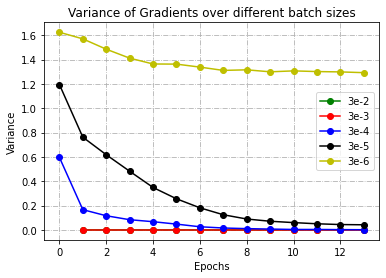

In [8]:
print ("var_gradients:\n", var_gradients_list)
import numpy as np
plt.plot(np.arange(epochs)[1:], var_gradients_list_lr[0][1:], marker='o', color = "g")
plt.plot(np.arange(epochs)[1:], var_gradients_list_lr[1][1:], marker='o', color = "r")
plt.plot(np.arange(epochs)[:], var_gradients_list_lr[2][:], marker='o', color = "b")
plt.plot(np.arange(epochs)[:], var_gradients_list_lr[3][:], marker='o', color = "k")
plt.plot(np.arange(epochs)[:], var_gradients_list_lr[4][:], marker='o', color = "y")
plt.grid(True, linestyle='-.')
plt.legend([ "3e-2", "3e-3", "3e-4", "3e-5", "3e-6"]) #loc='lower left'
plt.title("Variance of Gradients over different batch sizes")
plt.ylabel("Variance")
plt.xlabel("Epochs")
plt.show()	  

In [9]:
print (var_gradients_list_lr)
# why is variance of gradients zero ?????? did it get stuck at some point the curve ??? 

[[tensor(507.3162), tensor(3.4571e-05), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(7.1257), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(0.5963), tensor(0.1665), tensor(0.1164), tensor(0.0839), tensor(0.0676), tensor(0.0477), tensor(0.0259), tensor(0.0157), tensor(0.0106), tensor(0.0071), tensor(0.0037), tensor(0.0037), tensor(0.0024), tensor(0.0016)], [tensor(1.1953), tensor(0.7624), tensor(0.6181), tensor(0.4824), tensor(0.3489), tensor(0.2558), tensor(0.1818), tensor(0.1247), tensor(0.0896), tensor(0.0713), tensor(0.0601), tensor(0.0504), tensor(0.0441), tensor(0.0422)], [tensor(1.6252), tensor(1.5707), tensor(1.4858), tensor(1.4122), tensor(1.3642), tensor(1.3631), tensor(1.3385), tensor(1.3114), tensor(1.3162), tensor(1.2998), tensor(1.3075), tensor(1.301

In [10]:
print (var_gradients_list)


[[tensor(1.9956), tensor(1.8365), tensor(1.6858), tensor(1.5881), tensor(1.5500), tensor(1.5077), tensor(1.4969), tensor(1.4742), tensor(1.4648), tensor(1.4424), tensor(1.4456), tensor(1.4324), tensor(1.4476), tensor(1.4339)], [tensor(1.4371), tensor(1.3835), tensor(1.3150), tensor(1.2462), tensor(1.2094), tensor(1.1926), tensor(1.1712), tensor(1.1553), tensor(1.1699), tensor(1.1538), tensor(1.1603), tensor(1.1561), tensor(1.1516), tensor(1.1443)], [tensor(1.1337), tensor(1.1840), tensor(1.1069), tensor(1.0662), tensor(1.0577), tensor(1.0215), tensor(1.0376), tensor(1.0161), tensor(1.0145), tensor(1.0061), tensor(1.0002), tensor(0.9836), tensor(0.9899), tensor(0.9881)], [tensor(0.7599), tensor(0.8146), tensor(0.8026), tensor(0.7905), tensor(0.7652), tensor(0.7462), tensor(0.7453), tensor(0.7608), tensor(0.7329), tensor(0.7346), tensor(0.7302), tensor(0.7353), tensor(0.7307), tensor(0.7354)]]


step:0:
 [ 5.93779798e+03  1.06894133e+00 -3.88463883e-09 -3.88463883e-09
 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09
 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09
 -3.88463883e-09 -3.88463883e-09]
step:1:
 [ 1.06586288e+01 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09
 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09
 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09 -3.88463883e-09
 -3.88463883e-09 -3.88463883e-09]
step:2:
 [ 1.39401324e-01  2.25613890e-02  8.68815390e-03  7.73363463e-03
 -5.26640231e-03 -2.93582636e-05 -1.79003405e-03 -4.99494233e-03
 -6.92639668e-03 -6.51141176e-03 -1.15802454e-02 -1.17463165e-02
 -1.24551571e-02 -1.31056805e-02]
step:3:
 [ 0.09560027  0.00018759 -0.01626356 -0.02862007 -0.03651938 -0.03584595
 -0.0409042  -0.03996176 -0.0437227  -0.04383114 -0.04655619 -0.05068072
 -0.04839951 -0.04957003]
step:4:
 [ 0.16684449  0.01994953  0.00917276 -0.00034677 -0.00190678 -0.00586233
 -0.0083914  -0.0108260

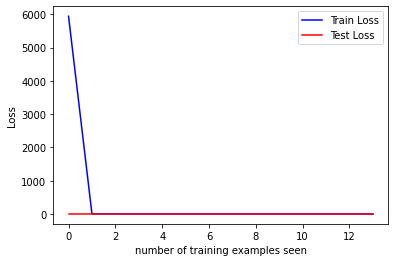

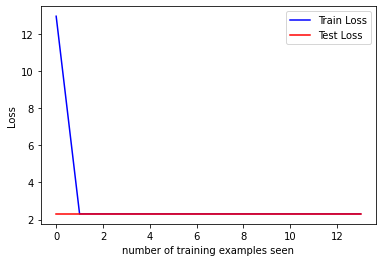

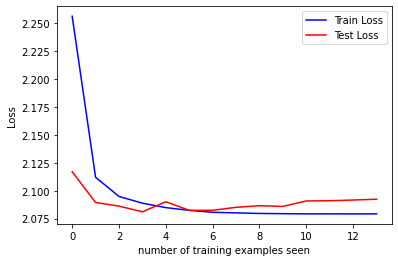

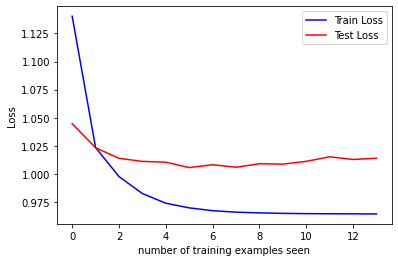

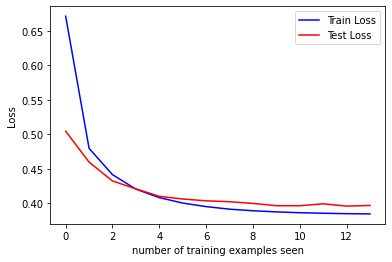

In [11]:
train_losses_copy = np.asarray(train_losses)
test_losses_copy = np.asarray(test_losses)

for i in range(len(train_losses_copy)):
    diff = train_losses_copy[i] - test_losses_copy[i]
    print ("step:"+str(i)+":\n", diff)

for i in range(len(train_losses_copy)):
    show_losses(train_losses_copy[i], test_losses_copy[i])



print (train_losses)

In [0]:
# print ("var_gradients:\n", var_gradients_list)
# import numpy as np
# plt.plot(np.arange(epochs), var_gradients_list, marker='o')
# plt.grid(True, linestyle='-.')
# # plt.legend() #loc='lower left'
# plt.title("Variance of Gradients")
# plt.ylabel("Variance")
# plt.xlabel("Epochs")
# plt.show()	  
# need to test this thing on other dataset